In [16]:
#Libraries for data path and filtering out warnings
import os
import warnings
warnings.filterwarnings('ignore')

#Core data analysis and visualization libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data preprocessing, metrics, and model selection libraries 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Model libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

path = os.path.join('pokemon.csv')
pokemon = pd.read_csv(path)
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Let's take a look at some summary statistics for this dataset.

In [17]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


Now, let's take a look at the correlation between Pokemon stats

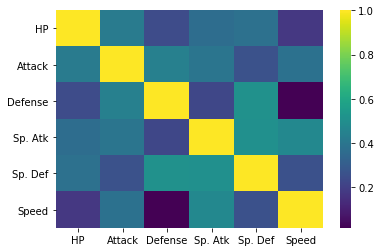

In [18]:
sns.heatmap( pokemon.loc[:, ['HP', 'Attack', "Defense", "Sp. Atk", 'Sp. Def', 'Speed']].corr(),cmap="viridis")

There looks to be a strong negative correlation between Defense and Speed. Maybe bulkier Pokemon are less fast as a result? 

Let's take a peek at the distribution of Pokemon across Pokemon types.

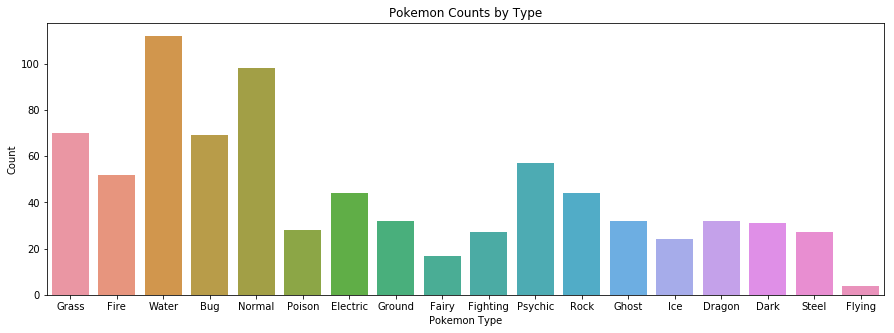

In [19]:
plt.subplots(figsize = (15,5))
sns.countplot(pokemon['Type 1'])
plt.xlabel('Pokemon Type')
plt.ylabel('Count')
plt.title('Pokemon Counts by Type')
plt.show()

The largest grouping of Pokmeon types is Water, with the lowest count of types is Flying. 

Let's make a plot of Total Stats by Pokemon Types and a Total Stat distribution over all Pokemon

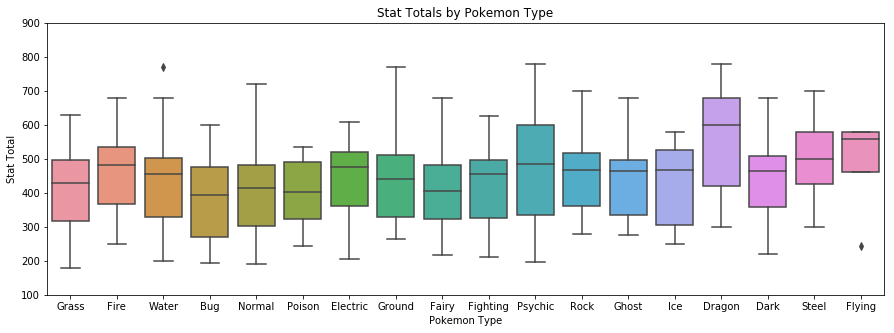

In [20]:
plt.subplots(figsize = (15,5))
plt.title('Totals of Type 1')
sns.boxplot(x = "Type 1", y = "Total",data = pokemon)
plt.ylim(100,900)
plt.xlabel('Pokemon Type')
plt.ylabel('Stat Total')
plt.title('Stat Totals by Pokemon Type')
plt.show()

Text(0, 0.5, 'Percentage')

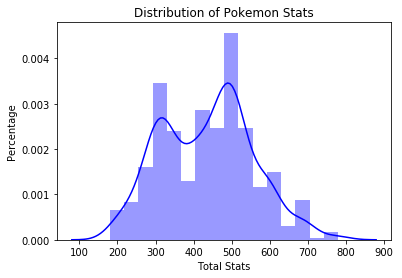

In [21]:
sns.distplot(pokemon['Total'],color='Blue')
plt.title('Distribution of Pokemon Stats')
plt.xlabel('Total Stats')
plt.ylabel('Percentage')

Unsurprising to most Pokemon fans, the Dragon Type looks to have higher stats than the other Pokemon Types. It also looks like most Pokemon have total stats around 500, but another local maximum is at 300. 

We're interested in using machine learning techniques to predict if a Pokemon is a Legendary Pokemon so let's look at some visualizations. 

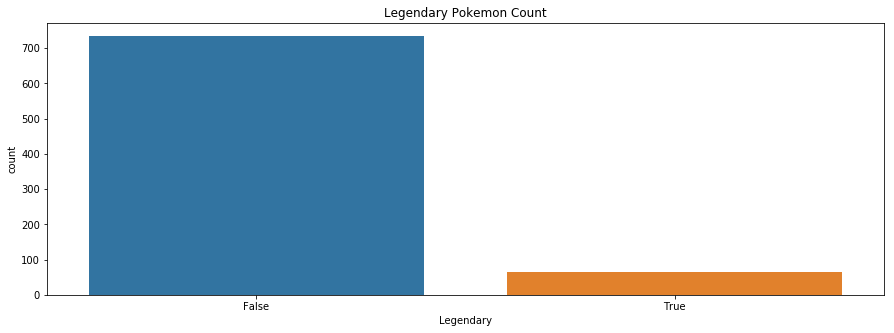

In [22]:
plt.subplots(figsize = (15,5))
sns.countplot(pokemon['Legendary'])
plt.title('Legendary Pokemon Count')
plt.show()

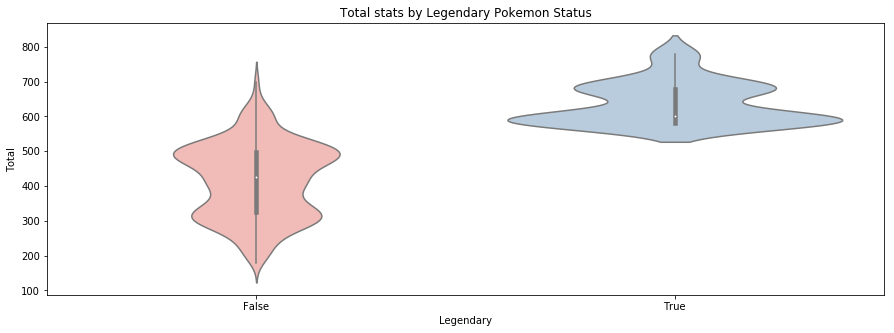

In [23]:
legends = pokemon[pokemon['Legendary'] == True]
plt.subplots(figsize = (15,5))
plt.title('Total stats by Legendary Pokemon Status')
sns.violinplot(
    x='Legendary',
    y='Total',
    palette = 'Pastel1',
    data=pokemon,
)

Unsurprisingly, Legendary Pokemon have higher stat totals than non-Legendary Pokemon.

Now, let's set the groundwork for creating our Legendary Pokemon classifiers. We'll preprocess the data by selecting the features we will use, the different types of stats each pokemons, to predict whether or not a Pokemon is a Legendary. We will also normalize the data and then create our training and testing splits, keeping out 10% of our data for testing. Because there are a much larger amount of non-Legendary Pokemon than Legendary Pokemon, we will use the SMOTE (Synthetic Minority Over-sampling Technique) to compensate for this. What the SMOTE algorithm does it create an axis on which the data points lie, then generates new, synthetic data points along those axis to simulate new data for us to use. This way we will also have a balanced dataset to compare to our non-balanced dataset to run our models on

In [24]:
#Data PreProcessing
x = pokemon[["HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"]]
y = pokemon['Legendary']

#Scale the data
scaler = StandardScaler().fit(x)
x = scaler.transform(x)
y = y.astype(int)

#Create training and testing data
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=27,test_size=0.1)

#Create SMOTE data 

sm = SMOTE(random_state = 7)

x_sm, y_sm = sm.fit_sample(x, y)

x_sm_train,x_sm_test,y_sm_train,y_sm_test = train_test_split(x_sm,y_sm,random_state=27,test_size = 0.1)

Let's start off with a baseline. A good baseline for classifiers is the Logistic Regression algorithm. Considered more crude than the models that will follow it, the Logistic Regression model should give us a good accuracy to beat. I will be making use of Cross Validation to train this algorithm. What Cross Validation does is divide our training data into folds, and then trains the data on different folds and tests it on others. What this does is let us get more mileage out of our training data and let us preview what our test accuracy will be, without using our testing data. 

In [42]:
def log_reg_iterator(x_data, y_data, cv_choice):
    logReg=LogisticRegression()
    scores = cross_val_score(logReg, x_train, y_train, cv= cv_choice)
    scores_avg = round(np.mean(scores),2)
    print(scores_avg *100)
    
    
log_reg_iterator(x_train,y_train, 10) 
log_reg_iterator(x_sm_train,y_sm_train, 10)

94.0
94.0


94% training accuracy for both of our datasets. Not bad! But I think we can do better. 

Next, I will explore a few other models. K-Nearest Neighbors, Support Vector Machine, and Random Forest. To better optimize these models, I will be making use of the grid search function. This function lets us specify a range of values for the hyperparameters (values chosen by the model designer that impact how the model runs, for example, the value of K for the K-Nearest Neighbors Algorithm). Grid search will go through these options, and pick the hyperparameters that delivered the best results, also making use of Cross Validation.

In [33]:
n_neighbors_list = [x for x in range(1,11)]
Cs = [0.001,0.01,0.1,1,10]
gammas = [0.001,0.01,0.1,1]
n_estimators_list = [x * 50 for x in range(1,11)]
max_depth_list = [x for x in range(1,26)]
model_list = [KNeighborsClassifier(),SVC(),RandomForestClassifier()]
param_dict_list = [{'n_neighbors': n_neighbors_list},{'C': Cs, 'gamma': gammas}, {'n_estimators': n_estimators_list, "max_depth": max_depth_list}]

def grid(model, param_dict_list,x,y,cv_folds):
    grid_search = GridSearchCV(model, param_dict_list, cv= cv_folds)
    grid_search.fit(x,y)
    grid_search.best_params_
    grid_search.best_score_
    print(grid_search.best_params_, round(grid_search.best_score_,3) *100)
    
for idx in range(len(model_list)):
    grid(model_list[idx], param_dict_list[idx],x_train,y_train,10)
    grid(model_list[idx], param_dict_list[idx],x_sm_train,y_sm_train,10)


{'n_neighbors': 5} 94.6
{'n_neighbors': 2} 97.89999999999999
{'C': 10, 'gamma': 0.01} 94.0
{'C': 10, 'gamma': 1} 98.3
{'max_depth': 3, 'n_estimators': 50} 94.39999999999999
{'max_depth': 17, 'n_estimators': 200} 98.0


Looks like the SMOTE dataset outperformed the non-SMOTE set in each of our models. The Support Vector Machine model with the SMOTE set performed the best, at 98.3%, followed closely by the Random Forest SMOTE set. 

Next, let's use these hyperparameters and run our models on the testing sets. I will be including F1, precision, and recall scores as well. The precision score will tell us how good our model is at finding true positives, while the recall score tells us how often the model finds the relevant points (true positives / true positives + false negatives). The F1 score is an average of the precision recall and is a good metric of the overall classification accuracy, a score of 1 being perfect and 0 being awful. 

In [40]:
#After optimizing hyperparameters and choosing best version of each model, run them together here
model_list = [LogisticRegression(),KNeighborsClassifier(n_neighbors = 5), SVC(C = 10, gamma = 0.01), RandomForestClassifier(n_estimators=50, max_depth=3)]

model_list_sm = [LogisticRegression(),KNeighborsClassifier(n_neighbors = 2), SVC(C = 10, gamma = 1), RandomForestClassifier(n_estimators=200, max_depth=17)]

#Run each model, get accuracy and classification metrics
def model_iterator(model, x_training, y_training, x_testing, y_testing):
    clf = model
    clf.fit(x_training, y_training)
    y_pred = model.predict(x_testing)
    print(round(accuracy_score(y_testing, y_pred),3) *100,f1_score(y_testing, y_pred),precision_score(y_testing, y_pred), recall_score(y_testing, y_pred))

for idx,clf in enumerate(model_list):
    model_iterator(model_list[idx],x_train,y_train, x_test,y_test)
    model_iterator(model_list[idx],x_sm_train, y_sm_train, x_sm_test,y_sm_test)
    

96.2 0.7692307692307693 1.0 0.625
95.19999999999999 0.9523809523809523 0.9090909090909091 1.0
97.5 0.8571428571428571 1.0 0.75
96.6 0.9655172413793104 0.9333333333333333 1.0
96.2 0.7692307692307693 1.0 0.625
95.19999999999999 0.9523809523809523 0.9090909090909091 1.0
95.0 0.6666666666666666 1.0 0.5
99.3 0.9929078014184397 0.9859154929577465 1.0


The model that performed the best was the Random Forest on the SMOTE dataset with a whopping 99.3% accuracy. This is pretty good. It also had a perfect recall score and a very high F1 score! 

To finish off, let's peak at the importance of each feature in the Random Forest Model

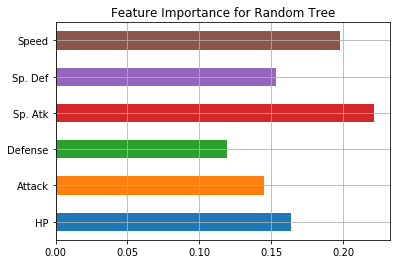

In [41]:
features_arr = ["HP","Attack","Defense","Sp. Atk","Sp. Def","Speed"]
clf = RandomForestClassifier(n_estimators=200, max_depth=17)
clf.fit(x_train,y_train)

feat_importances = pd.Series(clf.feature_importances_, index=features_arr)
feat_importances.plot(kind='barh',grid=True, title = "Feature Importance for Random Tree")

It looks like Special Attack and Speed are the most important features when predicting a Legendary Pokemon!